# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

from sklearn     import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [14]:
def bivariada(data, var_resposta:str, var_explicativa:str):
    biv = pd.crosstab(data[var_explicativa], 
                      data[var_resposta], 
                      margins=True,
                      margins_name= 'Total').rename(columns={0:'saudaveis', 1:'doentes'})
    
    biv['qnt_media_doentes'] = biv['doentes']/ biv['Total']
    biv['qnt_media_saudaveis'] = biv['saudaveis']/ biv['Total']
    
    biv['odds'] = biv['doentes']/ biv['saudaveis']
    biv['odds_ratio'] = biv['odds']/ biv.loc['Total', 'odds']
    biv['logito'] = np.log(biv['odds'])
    biv['WOE'] = np.log(biv['odds_ratio'])
    
    return biv 

In [17]:
biv_cp = bivariada(data=df, var_resposta= 'flag_doente', var_explicativa = 'cp')
biv_cp

flag_doente,saudaveis,doentes,Total,qnt_media_doentes,qnt_media_saudaveis,odds,odds_ratio,logito,WOE
cp,,,,,,,,,
1.0,16,7,23,0.304348,0.695652,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.820000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.790698,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,0.270833,2.692308,3.176536,0.990399,1.155791
Total,164,139,303,0.458746,0.541254,0.847561,1.000000,-0.165392,0.000000


In [18]:
biv_sex = bivariada(data=df, var_resposta= 'flag_doente', var_explicativa = 'sex')
biv_sex

flag_doente,saudaveis,doentes,Total,qnt_media_doentes,qnt_media_saudaveis,odds,odds_ratio,logito,WOE
sex,,,,,,,,,
0.0,72,25,97,0.257732,0.742268,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,0.446602,1.239130,1.461996,0.214410,0.379802
Total,164,139,303,0.458746,0.541254,0.847561,1.000000,-0.165392,0.000000


In [20]:
biv_exang = bivariada(data=df, var_resposta= 'flag_doente', var_explicativa = 'exang')
biv_exang

flag_doente,saudaveis,doentes,Total,qnt_media_doentes,qnt_media_saudaveis,odds,odds_ratio,logito,WOE
exang,,,,,,,,,
0.0,141,63,204,0.308824,0.691176,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,0.232323,3.304348,3.898655,1.195239,1.360632
Total,164,139,303,0.458746,0.541254,0.847561,1.000000,-0.165392,0.000000


Entre as três variáveis, a que mais parece discriminar o risco é ```exang``` (dor no peito causada por exercício), pois em relação as demais variáveis, é a que difere com maior valor de probabilidade entre os perfis,

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [25]:
def bivariada_quantitativa(data, var_resposta:str, var_explicativa:str, quebra_grupos:int=5):
    biv = pd.crosstab(data[var_explicativa], 
                      data[var_resposta], 
                      margins=True,
                      margins_name= 'Total').rename(columns={0:'saudaveis', 1:'doentes'})
    
    biv['cat'] = pd.qcut(x=data[var_explicativa], q=quebra_grupos)
    biv = biv.groupby('cat').agg('sum')
    biv = (pd.concat(objs=[biv, 
                           pd.DataFrame(data=biv.sum(axis=0), 
                                        columns=['Total']).T]))
    
    biv['qnt_media_doentes'] = biv['doentes']/ biv['Total']
    biv['qnt_media_saudaveis'] = biv['saudaveis']/ biv['Total']
    
    biv['odds'] = biv['doentes']/ biv['saudaveis']
    biv['odds_ratio'] = biv['odds']/ biv.loc['Total', 'odds']
    biv['logito'] = np.log(biv['odds'])
    biv['WOE'] = np.log(biv['odds_ratio'])
    
    return biv 

In [27]:
biv_age = bivariada_quantitativa(data=df, var_resposta= 'flag_doente', var_explicativa = 'age', quebra_grupos=5)
biv_age

flag_doente,saudaveis,doentes,Total,qnt_media_doentes,qnt_media_saudaveis,odds,odds_ratio,logito,WOE
"(28.999, 45.0]",41,22,63,0.349206,0.650794,0.536585,0.633094,-0.622530,-0.457137
"(45.0, 53.0]",26,40,66,0.606061,0.393939,1.538462,1.815163,0.430783,0.596175
"(53.0, 58.0]",35,43,78,0.551282,0.448718,1.228571,1.449538,0.205852,0.371245
"(58.0, 62.0]",37,22,59,0.372881,0.627119,0.594595,0.701536,-0.519875,-0.354483
"(62.0, 77.0]",25,12,37,0.324324,0.675676,0.480000,0.566331,-0.733969,-0.568577
Total,164,139,303,0.458746,0.541254,0.847561,1.000000,-0.165392,0.000000


In [28]:
biv_thalach = bivariada_quantitativa(data=df, var_resposta= 'flag_doente', var_explicativa = 'thalach')
biv_thalach

flag_doente,saudaveis,doentes,Total,qnt_media_doentes,qnt_media_saudaveis,odds,odds_ratio,logito,WOE
"(70.999, 130.0]",34,22,56,0.392857,0.607143,0.647059,0.763436,-0.435318,-0.269926
"(130.0, 146.0]",29,22,51,0.431373,0.568627,0.758621,0.895063,-0.276253,-0.110861
"(146.0, 159.0]",34,36,70,0.514286,0.485714,1.058824,1.249259,0.057158,0.222551
"(159.0, 170.0]",35,24,59,0.406780,0.593220,0.685714,0.809044,-0.377294,-0.211902
"(170.0, 202.0]",32,35,67,0.522388,0.477612,1.093750,1.290468,0.089612,0.255005
Total,164,139,303,0.458746,0.541254,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [34]:
reglog = smf.logit("flag_doente ~ sex + C(cp, Treatment(reference=4)) + trestbps + age"
                  ,data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 19 Mar 2024   Pseudo R-squ.:                  0.3097
Time:                        18:11:41   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -5.8619      1.413     -4.147      0.000      -8.632      -3.092
C(cp, Treatment(reference=4))[T.1.0]    -2.4789      0.553     -4.485      0.000      -3.562      -1.396
C(cp, Treatment(reference=4))[T.2.0]    -2.5406      0.452     -5.622      0.000      -3.426      -1.655
C(cp, Treatment(reference=4))[T.3.0]    -2.4074      0.360     -6.690      0.000      -3.113      -1.702
sex                                      1.8094      0.353      5.130      0.000       1.118       2.501
trestbps                                 0.0193      0.009      2.261      0.024       0.003       0.036
age                                      0.0567      0.018      3.120      0.002       0.021       0.092
========================================================================================================
"""

É possível concluir que todas as variáveis estão estatisticamente significativas para explicar a variável dependente, já que todos os p-values estão abaixo do nível de significância de 0,05. Além disso, a variável ```sex``` tem o coeficiente mais alto, indicando que é a variável com maior influência na determinação da presença ou ausência da doença cardíaca. 

In [39]:
print(f'A razão de chance de um homem apresentar doença cardíaca é de {round(np.exp(1.8094), 2)} vezes com relação a uma mulher.\n')

print(f'A razão de chance de uma pessoa com angina típica (valor 1) apresentar doença cardíaca é de {round(np.exp(-2.4789), 4)} vezes com relação a uma pessoa com tipo de dor no peito assintomático (valor 4).\n')
print(f'A razão de chance de uma pessoa com angina típica (valor 1) apresentar doença cardíaca é de {round(np.exp(-2.5406), 4)} vezes com relação a uma pessoa com tipo de dor no peito assintomático (valor 4).\n')
print(f'A razão de chance de uma pessoa com angina típica (valor 1) apresentar doença cardíaca é de {round(np.exp(-2.4074), 4)} vezes com relação a uma pessoa com tipo de dor no peito assintomático (valor 4).\n')

print(f'A razão de chance aumenta {round(np.exp(0.0193), 2)} para cada milímetro de mercúrio (mmHg) da pressão sanguínea na admissão ao hospital.\n')

print(f'A razão de chance aumenta {round(np.exp(0.0567), 2)} para cada ano da idade.\n')

A razão de chance de um homem apresentar doença cardíaca é de 6.11 vezes com relação a uma mulher.

A razão de chance de uma pessoa com angina típica (valor 1) apresentar doença cardíaca é de 0.0838 vezes com relação a uma pessoa com tipo de dor no peito assintomático (valor 4).

A razão de chance de uma pessoa com angina típica (valor 1) apresentar doença cardíaca é de 0.0788 vezes com relação a uma pessoa com tipo de dor no peito assintomático (valor 4).

A razão de chance de uma pessoa com angina típica (valor 1) apresentar doença cardíaca é de 0.09 vezes com relação a uma pessoa com tipo de dor no peito assintomático (valor 4).

A razão de chance aumenta 1.02 para cada milímetro de mercúrio (mmHg) da pressão sanguínea na admissão ao hospital.

A razão de chance aumenta 1.06 para cada ano da idade.



4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [40]:
df['predito'] = reglog.predict(df)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1,0.134492
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1,0.929259
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1,0.843216
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1,0.064913


In [41]:
# separar dados em 5 grupos

cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
cat_pred.value_counts()

predito
(0.0131, 0.143]    62
(0.287, 0.586]     62
(0.822, 0.944]     61
(0.143, 0.287]     59
(0.586, 0.822]     59
Name: count, dtype: int64

In [42]:
# agrupar dados usando os 5 grupos como referência 

group_reg = df.groupby(cat_pred)

qualid = (group_reg[['flag_doente']].count().rename(columns={'flag_doente':'contagem'}))
qualid

,contagem
predito,
"(0.0131, 0.143]",62
"(0.143, 0.287]",59
"(0.287, 0.586]",62
"(0.586, 0.822]",59
"(0.822, 0.944]",61


In [45]:
# média da previsão por grupo

qualid['predito'] = group_reg['predito'].mean()

# média de doentes observados por grupo

qualid['doentes'] = group_reg['flag_doente'].mean()

qualid

,contagem,predito,doentes
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


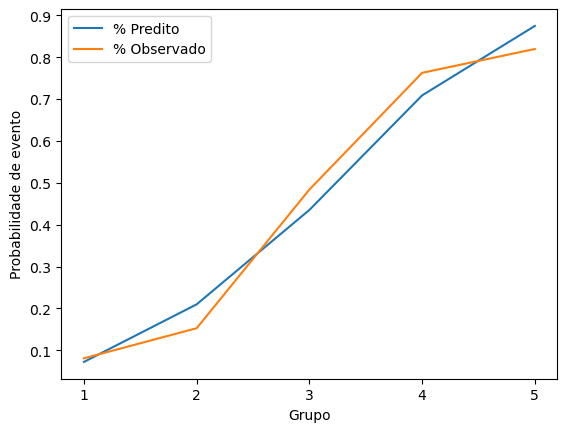

In [46]:
# Comparando graficamente o valor esperado versus observado para a taxa de maus por grupo:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax = qualid['predito'].plot(label='% Predito')
ax = qualid['doentes'].plot(label='% Observado')

ticks = ax.set_xticks(ticks=[0,1,2,3,4])
labels = ax.set_xticklabels([1,2,3,4,5])
ax.legend()
ax.set_xlabel(xlabel='Grupo')
ax.set_ylabel(ylabel='Probabilidade de evento')

plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [49]:
# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > .5)
print('Acurácia: {0:.2f}%'.format(acc*100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

# GINI
gini = 2 * auc_ -1

# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

# print(f'AUC: {auc_*100:.2f}%')
print(f'GINI: {gini*100:.2f}%')
print(f'KS: {ks*100:.2f}%')

Acurácia: 79.54%
GINI: 70.39%
KS: 59.30%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [52]:
reglog2 = smf.logit("flag_doente ~ sex + C(cp, Treatment(reference=4)) + age + thalach + exang + oldpeak"
                  ,data=df).fit()

reglog2.summary()

Optimization terminated successfully.
         Current function value: 0.414266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Tue, 19 Mar 2024   Pseudo R-squ.:                  0.3994
Time:                        19:52:38   Log-Likelihood:                -125.52
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 5.652e-32
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.6474      2.025     -0.320      0.749      -4.617       3.322
C(cp, Treatment(reference=4))[T.1.0]    -2.1539      0.594     -3.625      0.000      -3.319      -0.989
C(cp, Treatment(reference=4))[T.2.0]    -1.4851      0.485     -3.065      0.002      -2.435      -0.535
C(cp, Treatment(reference=4))[T.3.0]    -1.9797      0.405     -4.893      0.000      -2.773      -1.187
sex                                      1.6929      0.379      4.463      0.000       0.949       2.436
age                                      0.0394      0.020      1.984      0.047       0.000       0.078
thalach                                 -0.0192      0.009     -2.207      0.027      -0.036      -0.002
exang                                    0.8612      0.366      2.354      0.019       0.144       1.578
oldpeak                                  0.6968      0.170      4.108      0.000       0.364       1.029
========================================================================================================
"""

In [53]:
# calibragem

df['predito2'] = reglog2.predict(df)

# separar dados em 5 grupos

cat_pred2 = pd.qcut(df['predito2'], 5, duplicates='drop')

# agrupar dados usando os 5 grupos como referência 

group_reg2 = df.groupby(cat_pred2)

qualid2 = (group_reg2[['flag_doente']].count().rename(columns={'flag_doente':'contagem'}))

# média da previsão por grupo

qualid2['predito'] = group_reg2['predito2'].mean()

# média de doentes observados por grupo

qualid2['doentes'] = group_reg2['flag_doente'].mean()

qualid2

,contagem,predito,doentes
predito2,,,
"(0.0097, 0.103]",61,0.052069,0.032787
"(0.103, 0.264]",60,0.173365,0.233333
"(0.264, 0.583]",61,0.404910,0.360656
"(0.583, 0.883]",60,0.712810,0.733333
"(0.883, 0.997]",61,0.950061,0.934426


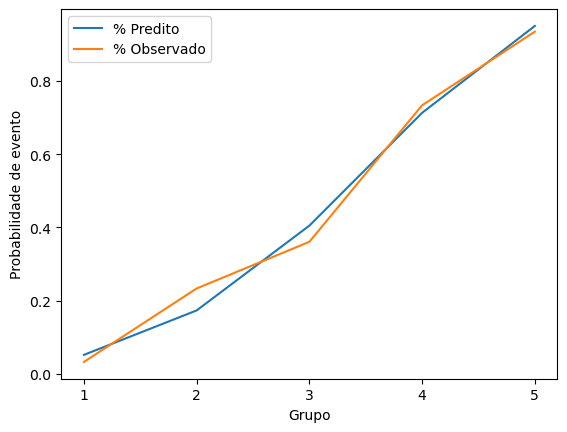

In [54]:
# Comparando graficamente o valor esperado versus observado para a taxa de maus por grupo:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax = qualid2['predito'].plot(label='% Predito')
ax = qualid2['doentes'].plot(label='% Observado')

ticks = ax.set_xticks(ticks=[0,1,2,3,4])
labels = ax.set_xticklabels([1,2,3,4,5])
ax.legend()
ax.set_xlabel(xlabel='Grupo')
ax.set_ylabel(ylabel='Probabilidade de evento')

plt.show()

In [55]:
# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito2'] > .5)
print('Acurácia: {0:.2f}%'.format(acc*100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito2'])
auc_ = metrics.auc(fpr, tpr)

# GINI
gini = 2 * auc_ -1

# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito2'], df.loc[df['flag_doente'] != 1, 'predito2']).statistic

# print(f'AUC: {auc_*100:.2f}%')
print(f'GINI: {gini*100:.2f}%')
print(f'KS: {ks*100:.2f}%')

Acurácia: 82.84%
GINI: 78.04%
KS: 66.27%
